In [3]:
! pip install segmentation_models
! pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 30.1 MB/s eta 0:00:0000:0100:01


In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Model stuff
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.utils import normalize
import segmentation_models as sm
from sklearn.model_selection import train_test_split

import model_utility_rpjb
import preprocess_filter
import spoketools

#path sorting
import glob
from pathlib import Path
import re

#math
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

Segmentation Models: using `tf.keras` framework.


In [2]:
model_path = "models/rpjb_models/"
type = "all_fixed_norm"
training_size = "170"
epoch_num = "700"
backbone = "resnet34"

model_path = f"{model_path}{type}_spoke_{training_size}im_{epoch_num}e_{backbone}.h5"

In [6]:
X, Y = [], []

X, Y = model_utility_rpjb.data_gather(X, Y, "spokes_all_rpjbs", "spokes_all_masks")

170 170


In [7]:
X = normalize(np.array(X))
Y = np.array(Y)

# train/test split test_size = .15 for light, .25 for dark(no agu)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)

SIZE_Y, SIZE_X = X.shape[1], X.shape[2]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(144, 160, 736)
(26, 160, 736)
(144, 160, 736)
(26, 160, 736)


In [8]:
model = model_utility_rpjb.define_model(SIZE_Y, SIZE_X, backbone)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 160, 736, 1  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 160, 736, 1)  3           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 166, 742, 1)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 80, 368, 64)  3136        ['zero_padding2d[0][0]']   

In [9]:
history = model_utility_rpjb.fit_model(x_train, y_train, model, model_path, batch_size = 10, epochs = int(epoch_num), validation_split = .13)

results = model.evaluate(x_test, y_test)

model_utility_rpjb.save_model_history(model_path, model, history, results)

Epoch 1/300
13/13 [==============================] - ETA: 0s - loss: 0.3526 - iou_score: 0.0284
Epoch 1: val_iou_score improved from -inf to 0.00086, saving model to models/rpjb_models/all_fixed_norm_spoke_170im_300e_resnet34.h5
13/13 [==============================] - 20s 641ms/step - loss: 0.3526 - iou_score: 0.0284 - val_loss: 0.3321 - val_iou_score: 8.5880e-04
Epoch 2/300
13/13 [==============================] - ETA: 0s - loss: 0.1704 - iou_score: 0.0378
Epoch 2: val_iou_score did not improve from 0.00086
13/13 [==============================] - 2s 192ms/step - loss: 0.1704 - iou_score: 0.0378 - val_loss: 0.3121 - val_iou_score: 4.4111e-04
Epoch 3/300
13/13 [==============================] - ETA: 0s - loss: 0.1185 - iou_score: 0.0695
Epoch 3: val_iou_score did not improve from 0.00086
13/13 [==============================] - 3s 193ms/step - loss: 0.1185 - iou_score: 0.0695 - val_loss: 0.3113 - val_iou_score: 4.4192e-04
Epoch 4/300
13/13 [==============================] - ETA: 0s - 

Which model is this? - all_fixed_norm_spoke_170im_300e_resnet34.json


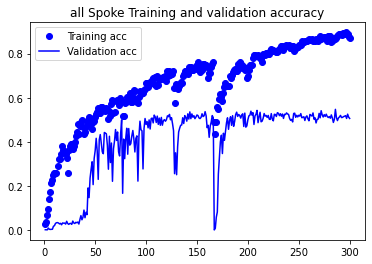

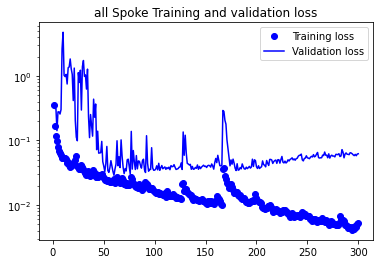

Last Train IOU Score:  0.8688499927520752
Last Train Loss Score:  0.005262530874460936
Last Validation IOU Score:  0.5058510303497314
Last Validation Loss Score:  0.062275245785713196
all_fixed_norm
170
300


In [10]:
model_utility_rpjb.display_results(model_path)
print(type)
print(training_size)
print(epoch_num)

In [3]:
model = keras.models.load_model(model_path, compile = False)
model.compile(optimizer = "Adam" , loss = "binary_crossentropy", metrics = [sm.metrics.IOUScore()], )

print(type)
print(training_size)
print(epoch_num)

model_utility_rpjb.model_testing(model, "spokes_test_rpjbs", 15)

OSError: No file or directory found at models/rpjb_models/all_fixed_spoke_170im_300e_resnet34.h5